In [1]:
import pandas as pd

df = pd.read_csv("../data/patients/patients_donnees_journalieres_reconstituees.csv")
df["date"] = pd.to_datetime(df["date"])

ts = df[
    (df["site_code"] == "PLF") &
    (df["indicateur"] == "Causes d'hopitalisations") &
    (df["sous_indicateur"] == "Pathologies cancéreuses - Total")
].set_index("date")["value"].asfreq("D")

In [2]:
ts.groupby(ts.index.dayofweek).mean()

date
0    50.932907
1    50.833866
2    51.507987
3    51.779553
4    52.246006
5    39.503185
6    38.977636
Name: value, dtype: float64

In [3]:
ts.groupby(ts.index.month).mean()

date
1     84.790323
2     61.858824
3     39.553763
4     35.038889
5     28.290323
6     35.061111
7     73.462366
8     73.489247
9     35.038889
10    28.241935
11    23.366667
12    56.537634
Name: value, dtype: float64

In [5]:
import pandas as pd

df = pd.read_csv("../data/patients/patients_donnees_journalieres_reconstituees.csv")
df["date"] = pd.to_datetime(df["date"])

# Filtrer ta série homogène
df_plf = df[
    (df["site_code"] == "PLF") &
    (df["indicateur"] == "Causes d'hopitalisations") &
    (df["sous_indicateur"] == "Pathologies cancéreuses - Total")
]

# Série temporelle journalière
ts = df_plf.set_index("date")["value"].asfreq("D")

# Remplir les jours manquants (si besoin)
ts = ts.fillna(method="ffill")

/var/folders/p2/fks47gqx4g7fnqm1bp14v6t80000gn/T/ipykernel_67263/457033216.py:17: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ts = ts.fillna(method="ffill")


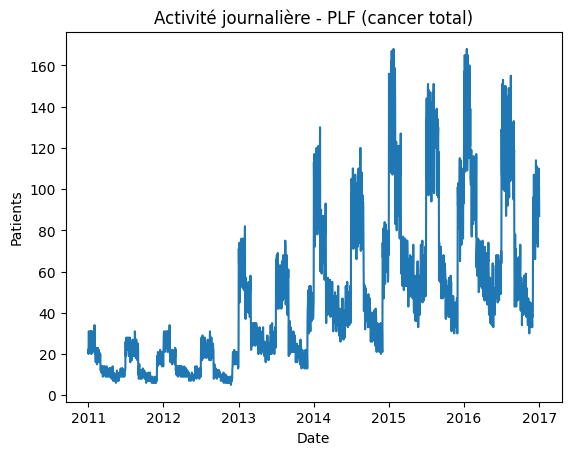

In [6]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(ts)
plt.title("Activité journalière - PLF (cancer total)")
plt.xlabel("Date")
plt.ylabel("Patients")
plt.show()

In [9]:
pip install statsmodels

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 12.5 MB/s  0:00:00m0:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.1/20.1 MB 13.3 MB/s  0:00:01 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [statsmodels] [statsmodels]
Note: you may need to restart the kernel to use updated packages.


In [10]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(
    ts,
    order=(1,1,1),          # tendance
    seasonal_order=(1,1,1,7) # saison hebdomadaire
)

results = model.fit()
print("Modèle entraîné ✅")

Modèle entraîné ✅


In [11]:
forecast = results.get_forecast(steps=30)

pred = forecast.predicted_mean
conf = forecast.conf_int()

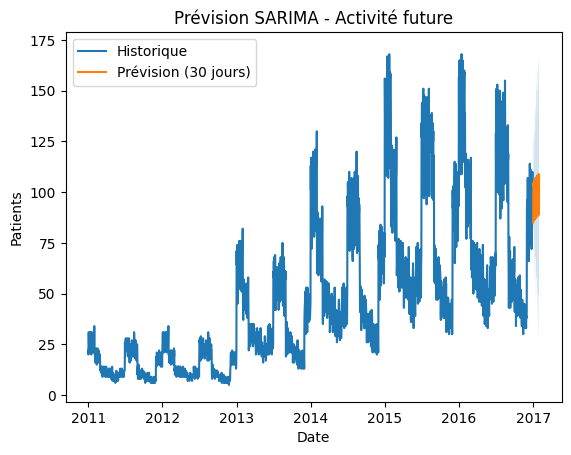

In [12]:
plt.figure()
plt.plot(ts, label="Historique")
plt.plot(pred, label="Prévision (30 jours)")

plt.fill_between(
    conf.index,
    conf.iloc[:, 0],
    conf.iloc[:, 1],
    alpha=0.2
)

plt.title("Prévision SARIMA - Activité future")
plt.xlabel("Date")
plt.ylabel("Patients")
plt.legend()
plt.show()

In [13]:
seuil_pic = ts.mean() + ts.std()

pics = pred[pred > seuil_pic]

print("Dates à risque de pic :")
print(pics)

Dates à risque de pic :
2017-01-01     85.019728
2017-01-02    104.380916
2017-01-03    102.868785
2017-01-04    105.008320
2017-01-05    102.417212
2017-01-06    105.722580
2017-01-07     87.222943
2017-01-08     86.392904
2017-01-09    105.555640
2017-01-10    103.053762
2017-01-11    104.730649
2017-01-12    104.746407
2017-01-13    107.211492
2017-01-14     87.903621
2017-01-15     87.280846
2017-01-16    106.407980
2017-01-17    103.728084
2017-01-18    105.321752
2017-01-19    105.806465
2017-01-20    108.120391
2017-01-21     88.667127
2017-01-22     88.081636
2017-01-23    107.202366
2017-01-24    104.490446
2017-01-25    106.069144
2017-01-26    106.638218
2017-01-27    108.924952
2017-01-28     89.445532
2017-01-29     88.866749
2017-01-30    107.986326
Freq: D, Name: predicted_mean, dtype: float64


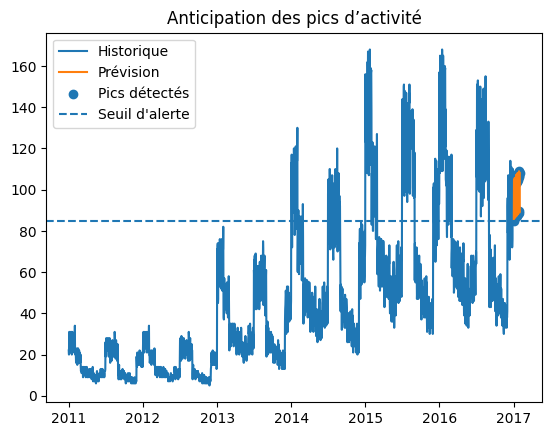

In [14]:
plt.figure()
plt.plot(ts, label="Historique")
plt.plot(pred, label="Prévision")

# Points rouges = pics
plt.scatter(pics.index, pics.values, label="Pics détectés")

plt.axhline(seuil_pic, linestyle="--", label="Seuil d'alerte")

plt.title("Anticipation des pics d’activité")
plt.legend()
plt.show()

In [15]:
forecast_2017 = results.get_forecast(steps=365)

pred_2017 = forecast_2017.predicted_mean
conf_2017 = forecast_2017.conf_int()

In [16]:
print(pred_2017.head())
print(pred_2017.tail())

2017-01-01     85.019728
2017-01-02    104.380916
2017-01-03    102.868785
2017-01-04    105.008320
2017-01-05    102.417212
Freq: D, Name: predicted_mean, dtype: float64
2017-12-27    143.581964
2017-12-28    144.169542
2017-12-29    146.450311
2017-12-30    126.965155
2017-12-31    126.387842
Freq: D, Name: predicted_mean, dtype: float64


In [17]:
print(results.summary())

                                     SARIMAX Results                                     
Dep. Variable:                             value   No. Observations:                 2192
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 7)   Log Likelihood               -7696.803
Date:                           Thu, 05 Feb 2026   AIC                          15403.607
Time:                                   17:06:54   BIC                          15432.052
Sample:                               01-01-2011   HQIC                         15414.005
                                    - 12-31-2016                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2857      0.039      7.405      0.000       0.210       0.361
ma.L1         -0.6010      0.032    -18.881